<a href="https://colab.research.google.com/github/SFIComplexityExplorer/Mesa-ABM-Tutorial/blob/main/Session_12_Traders_Move_part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 引入依赖包

In [1]:

try: 
  import mesa
except: 
  !pip install mesa --quiet
import mesa
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

# 辅助函数

In [2]:
def get_distance(pos_1, pos_2):
  '''
  计算两点欧式距离
  
  在交易主体移动函数：trade.move()中被调用
  '''

  x1, y1 = pos_1
  x2, y2 = pos_2
  dx = x1 - x2
  dy = y1 - y2
  return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
  '''
  将一个嵌套的列表展平为一个单一的列表
  '''
  return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
  '''
  计算一系列价格的几何平均数
  '''
  return np.exp(np.log(list_of_prices).mean())

# 资源类 

In [3]:
class Sugar(mesa.Agent):
    '''
    Sugar:
    - 包含一定数量的糖
    - 每轮增长一单位数量的糖
    '''
    def __init__(self, unique_id, model, pos, max_sugar): 
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar


    def step(self):
        '''
        糖每轮增长一单位数量
        '''
        self.amount = min([self.max_sugar, self.amount+1])

In [4]:
class Spice(mesa.Agent):
  '''
  spice:
  - 包含一定数量的香料
  - 每轮增长一单位数量的香料
  '''

  def __init__(self, unique_id, model, pos, max_spice):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_spice
    self.max_spice = max_spice
  
  def step(self): 
    '''
    香料每轮增长一单位数量
    '''
    self.amount = min([self.max_spice, self.amount+1])

# 交易主体类

In [5]:
class Trader(mesa.Agent): 
    '''
    Trader:
    - 能够代谢糖和香料
    - 收集和交易糖和香料来生存与繁衍
    '''


    def __init__(self, unique_id, model, pos, moore=False, sugar=0, 
               spice=0, metabolism_sugar=0, metabolism_spice=0, 
               vision=0):
      super().__init__(unique_id, model)
      self.pos = pos
      self.moore = moore
      self.sugar = sugar
      self.spice = spice
      self.metabolism_sugar = metabolism_sugar
      self.metabolism_spice = metabolism_spice
      self.vision = vision
      self.prices = []
      self.trade_partners = []

    
    def get_sugar(self, pos):
      '''
      在self.get_sugar_amount()中被调用
      '''

      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell:
        if type(agent) is Sugar:
          return agent
      return None
    
    
    def get_sugar_amount(self,pos):
      '''
      在self.move()中self.calculate_welfare()部分被调用
      '''

      sugar_patch = self.get_sugar(pos)
      if sugar_patch:
        return sugar_patch.amount
      return 0
    
    def get_spice(self, pos):
      '''
      在 self.get_spice_amount()中被调用
      '''

      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell: 
        if type(agent) is Spice: 
          return agent
      return None

    def get_spice_amount(self, pos):
      '''
      在self.move()中self.calculate_welfare()部分被调用
      '''

      spice_patch = self.get_spice(pos)
      if spice_patch: 
        return spice_patch.amount
      return 0
    


    def is_occupied_by_other(self,pos):
      '''
      辅助函数1：在self.move()的第一部分被调用
      '''

      if pos == self.pos: 
        # 主体本来的位置被视作未被占据，因为主体可以选择待在原地不动
        return False
      # 获取pos位置的所有agent
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for a in this_cell: 
        # 判断是否被其它交易主体占据
        if isinstance(a, Trader): 
          return True
      return False
    
    def calculate_welfare(self, sugar, spice):
      '''
      辅助函数2: 在self.move()的第二部分被调用
      '''




      # calculate total resources
      m_total = self.metabolism_sugar + self.metabolism_spice
      # Cobb-Douglas functional form    
      return sugar**(self.metabolism_sugar/m_total) * spice**(
          self.metabolism_spice/m_total)
    

    def is_starved(self):
        '''
        辅助函数3: 在elf.maybe_die()中被调用
        '''

        return (self.sugar <= 0) or (self.spice <= 0)

    def get_trader(self, pos):
        '''
        辅助函数4: 在self.trade_with_neighbors()中被调用
        '''

        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell: 
          if isinstance(agent, Trader):
            return agent
    

    def calculate_MRS(self, sugar, spice):
      '''
      辅助函数5: 在self.trade()中被调用

      决定交易主体需要什么和放弃什么
      '''

      return (spice/self.metabolism_spice) / (sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
      '''
      辅助函数6: 在self.maybe_sell_spice()中被调用
      self.maybe_sell_spice()则被self.trade()调用
      '''

      if price >= 1: 
        sugar = 1
        spice = int(price)
      else: 
        sugar = int(1/price)
        spice = 1
      return sugar, spice
    
    def sell_spice(self, other, sugar, spice):
      '''
      辅助函数7: 在self.maybe_sell_spice()中被调用

      在交易主体间交换糖和香料
      '''

      self.sugar += sugar
      other.sugar -= sugar
      self.spice -= spice
      other.spice += spice

      
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
      '''
      辅助函数8: 在self.trade()中被调用
      '''

      sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

      # 如果确实发生了交易-评估新的糖和香料量
      self_sugar = self.sugar + sugar_exchanged
      other_sugar = other.sugar - sugar_exchanged
      self_spice = self.spice - spice_exchanged
      other_spice = other.spice + spice_exchanged

      # 再次检查，确保交易主体有资源，若没有就不交易，直接返回False

      if ((self_sugar <= 0) or
          (other_sugar <=0) or 
          (self_spice <= 0) or
          (other_spice <= 0)):
        return False

      # 交易标准1——双方都变得更好吗?
      both_agents_better_off = (
          (welfare_self < self.calculate_welfare(self_sugar, self_spice)) and
          (welfare_other < other.calculate_welfare(other_sugar, other_spice)))
      
      # 交易标准2——是他们边际替代率相近吗？
      mrs_not_crossing = self.calculate_MRS(self_sugar, self_spice
                                            ) > other.calculate_MRS(
                                                other_sugar, other_spice
                                                )

      if not (both_agents_better_off and mrs_not_crossing):
        return False

      # 标准达到，执行交易
      self.sell_spice(other, sugar_exchanged, spice_exchanged)

      return True

    
    def trade(self, other):
      '''
      辅助函数9: 在self.trade_with_neighbors()中被调用

      other 是交易主体类
      '''

      # 完整性检查以验证代码是否按预期工作
      assert self.sugar > 0
      assert self.spice > 0
      assert other.sugar > 0
      assert other.spice > 0
    
      # 计算边际替代率《Growing Artificial Socieites》p. 101
      mrs_self = self.calculate_MRS(self.sugar, self.spice)
      mrs_other = other.calculate_MRS(other.sugar, other.spice)

      # 计算每个交易主体的福利
      welfare_self = self.calculate_welfare(self.sugar, self.spice)
      welfare_other = other.calculate_welfare(other.sugar, other.spice)

      if math.isclose(mrs_self, mrs_other, rel_tol=1e-02): 
        return

      # 计算价格
      price = math.sqrt(mrs_self*mrs_other)
      
      if mrs_self > mrs_other: 
        # 本交易主体买糖，卖香料
        sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
        # 如果标准未达到——交易结束，直接返回
        if not sold: 
          return
      else: 
        # 本交易主体买香料，卖糖
        sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
        # 如果标准未达到——交易结束，直接返回
        if not sold: 
          return
      
      # 存储数据
      self.prices.append(price)
      self.trade_partners.append(other.unique_id)

      # 继续交易，一直到交易标准不能满足为止
      self.trade(other)
    
    ######################################################################
    #                                                                    #  
    #                      MAIN TRADE FUNCTIONS                          #  
    #                                                                    #
    ######################################################################
    
    
    def move(self):
      '''
      通过四个步骤，为交易主体代理确定最优移动的功能
      1 - 找出所有可能的走法
      2 - 确定哪一步能使福利最大化
      3 - 找到最近的最佳选择
      4 - 移动
      '''

      # 1. 找出所有可能的走法

      neighbors = [i
                  for i in self.model.grid.get_neighborhood(
                    self.pos, self.moore, True, self.vision  
                  ) if not self.is_occupied_by_other(i)]

      # 2. 确定哪一步能使福利最大化

      welfares = [
          self.calculate_welfare(
              self.sugar + self.get_sugar_amount(pos),
              self.spice + self.get_spice_amount(pos)) 
          for pos in neighbors
      ]

      # 3. 找到最近的最佳选择

      # 找到其中最大的福利
      max_welfare = max(welfares)
      # 找出最大福利的在所有可能的走法中的索引（最大值可能不只一个）作为候选的索引
      candidate_indices = [i for i in range(len(welfares))
                          if math.isclose(welfares[i], max_welfare)]

      # 将索引转换为坐标作为候选
      candidates = [neighbors[i] for i in candidate_indices]
      # 找到最近的最佳选择（也可能不止一个）
      min_dist = min(get_distance(self.pos, pos) for pos in candidates)

      final_candidates = [ pos for pos in candidates
                        if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02
                                        )]
      self.random.shuffle(final_candidates) # 随机打乱顺序，以防止主体总是选择同一个方向

      # 4. 移动
      self.model.grid.move_agent(self, final_candidates[0])

    def eat(self):
      # 收获糖
      sugar_patch = self.get_sugar(self.pos)

      if sugar_patch:
          self.sugar += sugar_patch.amount
          sugar_patch.amount = 0
      self.sugar -= self.metabolism_sugar  # 代谢糖

      # 收获香料
      spice_patch = self.get_spice(self.pos)

      if spice_patch:
          self.spice += spice_patch.amount
          spice_patch.amount = 0
      self.spice -= self.metabolism_spice  # 代谢香料

    def maybe_die(self):
      '''
      消耗完糖或者香料后，交易主体死亡
      '''

      if self.is_starved(): 
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)

    def trade_with_neighbors(self):
      '''
      交易主体决定与谁交易的功能，分为三个部分

      1- 找出能与之交易的邻居
      2- 交易（两个步骤）
      3- 收集数据
      '''

      neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
          self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
      ]

      if len(neighbor_agents) == 0: 
        return
      

      # 便利能与之交易的邻居，进行交易
      for a in neighbor_agents: 
        if a: 
          self.trade(a)

      return

# 模型类

In [6]:
class SugarscapeG1mt(mesa.Model):
  '''
  通过Traders (GImt)来运行Sugarscape的模型
  来自 Axtell和Epstein《Growing Artifical Societies》
  '''
  
  def __init__(self, width=50,height=50, initial_population=200,
               endowment_min=25, endowment_max=50, metabolism_min=1,
               metabolism_max=5, vision_min=1, vision_max=5):
    
    # 初始化糖景的宽度和高度
    self.width = width
    self.height = height 
    # 初始化交易主体属性
    self.initial_population = initial_population
    self.endowment_min = endowment_min
    self.endowment_max = endowment_max
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max

    # 初始化mesa的日程表
    self.schedule = mesa.time.RandomActivationByType(self)    
    # 初始化mesa的网格类
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
    # 初始化数据收集器
    self.datacollector = mesa.DataCollector(
        {"Trader": lambda m: m.schedule.get_type_count(Trader),
         "Trade Volume": lambda m: sum(len(a.trade_partners)
         for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))}
    )
    # 从辅助资料中读取糖和香料的分布
    sugar_distribution =np.genfromtxt("sugar-map.txt")
    spice_distribution = np.flip(sugar_distribution, 1)
    
    agent_id = 0
    for _,x,y in self.grid.coord_iter():
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0: 
        sugar = Sugar(agent_id, self, (x,y), max_sugar)
        self.schedule.add(sugar)
        self.grid.place_agent(sugar, (x,y))
        agent_id += 1
    
      max_spice = spice_distribution[x,y]
      if max_spice > 0: 
        spice = Spice(agent_id, self, (x,y), max_spice)
        self.schedule.add(spice)
        self.grid.place_agent(spice, (x,y))
        agent_id += 1    

    for i in range(self.initial_population):
      # 得到随机的坐标
      x = self.random.randrange(self.width)
      y = self.random.randrange(self.height)
      # see Growing Artificial Societies p. 108 for initialization
      # 给予主体初始的禀赋
      sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      # 给予主体初始代谢
      metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      # 给予主体视野
      vision = int(self.random.uniform(self.vision_min, self.vision_max+1))
      # 实例化交易主体
      trader = Trader(agent_id, 
                      self,
                      (x,y),
                      moore = False, 
                      sugar = sugar, 
                      spice = spice, 
                      metabolism_sugar = metabolism_sugar, 
                      metabolism_spice = metabolism_spice, 
                      vision = vision)
      # 放置主体到网格中
      self.grid.place_agent(trader, (x,y))
      self.schedule.add(trader)
      agent_id += 1

  def randomize_traders(self): 
    '''
    在self.step()中被调用

    将交易主体的顺序打乱，以便在每一步中随机激活交易主体
    '''

    trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
    self.random.shuffle(trader_shuffle)

    return trader_shuffle
  

  def step(self):
    '''
    独特的step函数，可分阶段激活糖和香料 然后随机激活交易主体
    '''    

    # step Sugar agents
    for sugar in self.schedule.agents_by_type[Sugar].values(): 
      sugar.step()
    
    # step Spice agents
    for spice in self.schedule.agents_by_type[Spice].values(): 
      spice.step()

    # step trader agents
    # 为了考虑代理的死亡和移除，我们需要一个单独的数据结构来进行迭代
    trader_shuffle = self.randomize_traders()

    for agent in trader_shuffle: 
      agent.prices = []
      agent.trade_partners = []
      agent.move()
      agent.eat()
      agent.maybe_die()
      
    # 重新获取随机排序的交易主体的列表
    trader_shuffle = self.randomize_traders()

    for agent in trader_shuffle:
      agent.trade_with_neighbors()

    self.schedule.steps += 1 # 对于数据收集器(data collector)跟踪步数很重要

    # 收集模型层面的数据
    self.datacollector.collect(self)

  def run_model(self, step_count=1000):

    for i in range(step_count):
      self.step()

# 运行Sugarscape模型

In [7]:
model = SugarscapeG1mt()
model.run_model()  #  默认1000步


/var/folders/ty/bz5xq0491m9b5r2v1l_1t12w0000gn/T/ipykernel_32913/3152229916.py:24: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/Users/chowraffer/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# 数据分析

In [8]:
results = model.datacollector.get_model_vars_dataframe()

results

,Trader,Trade Volume,Price
0,200,764,1.057421
1,200,98,1.025708
2,200,181,1.091562
3,200,109,1.152485
4,200,67,1.323300
...,...,...,...
995,73,7,0.959856
996,73,6,1.042148
997,73,5,0.980586
998,73,9,0.935669


<Axes: >

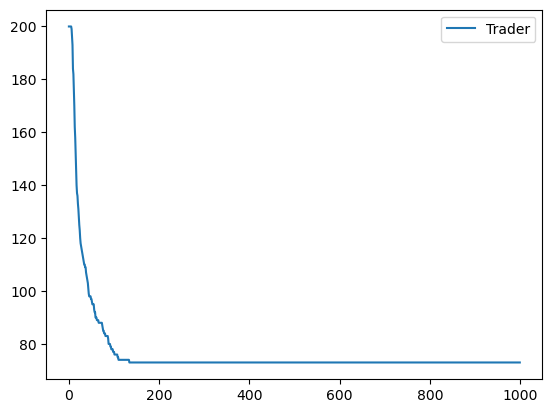

In [9]:
# 画出每一步的交易主体数量
results.plot(y = "Trader", use_index=True)

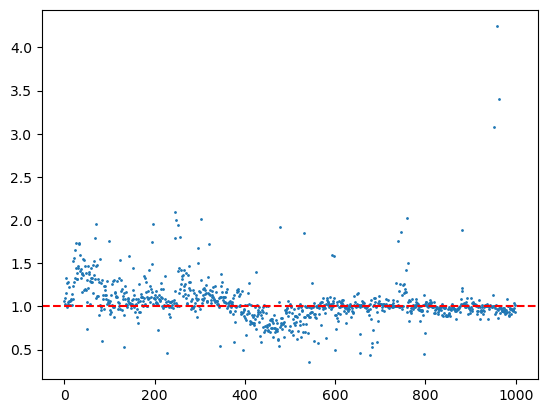

In [10]:
# 画出每一步的交易价格
y = list(results["Price"])
x = range(1000)

plt.scatter(x,y, s=1)
# 画出价格1的水平线
plt.axhline(y=1, color='r', linestyle='--')

<BarContainer object of 990 artists>

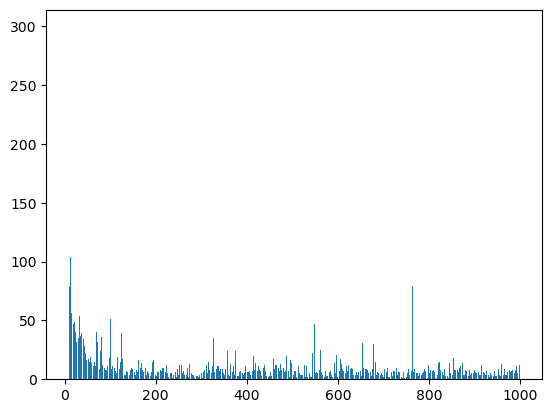

In [11]:
# 画出每一步的交易量（去掉前10步）

plt.bar(results.index[10:], results["Trade Volume"][10:])

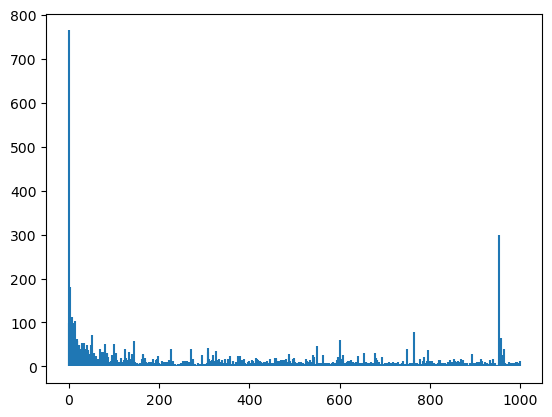

In [12]:
# 绘制改进后的交易量图
for i in range(1000):
  plt.vlines(i,0,results["Trade Volume"][i])
plt.show()